## Lecture - 4: Introducting Convolutional Neural Networks
- Lets look at the problem that traditional NN face when training images.  Consder the fashionMNIST data we worked with in the __building deep neuralnetwork with pytorch notebook__


100%|██████████| 26421880/26421880 [00:13<00:00, 2009813.92it/s]


Extracting /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 322304.45it/s]


Extracting /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5817889.17it/s]


Extracting /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10238158.84it/s]


Extracting /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/rajmani/Documents/research/Home/python/computer-vision/datasets/FashionMNIST/raw



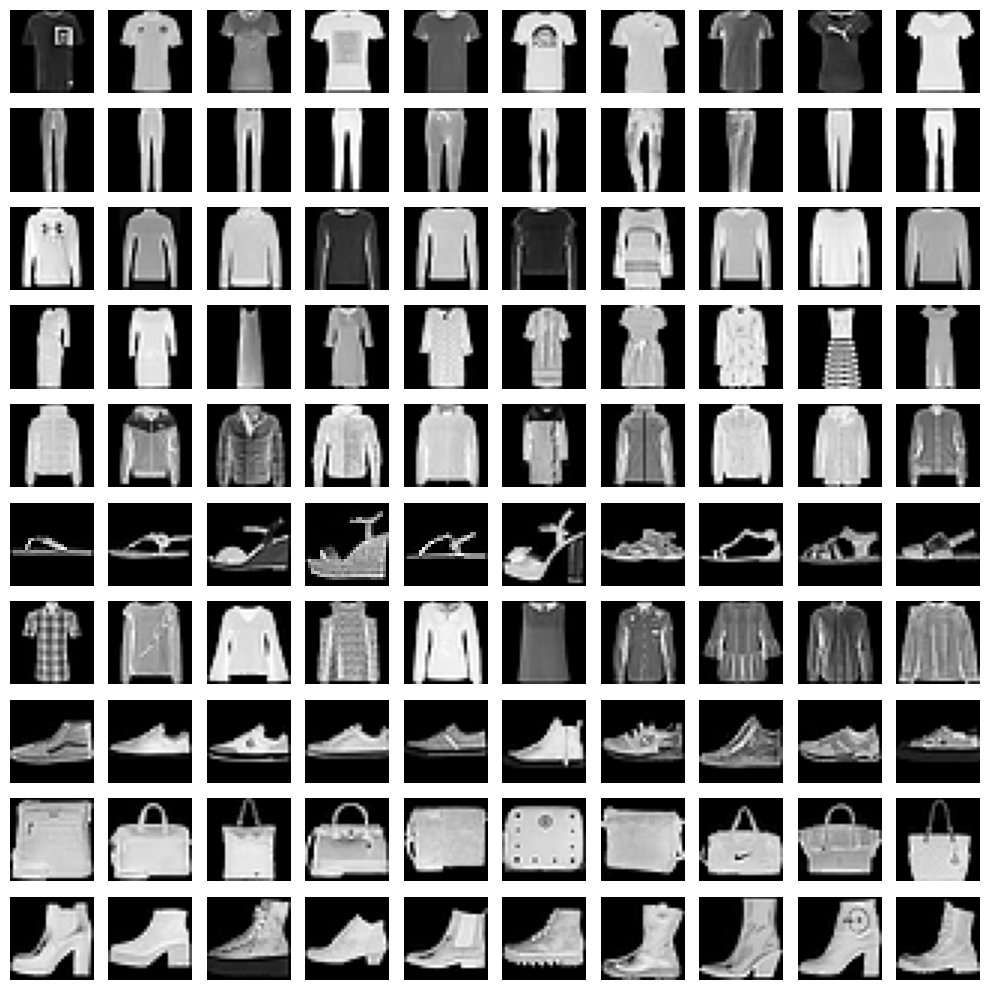

In [1]:
from torchvision import datasets 
import os
import numpy as np
import matplotlib.pyplot as plt
path = os.path.join(os.getcwd(), 'datasets')
fmnist = datasets.FashionMNIST(path, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10, 10))
for label, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False);
        plot_cell.axis('off');
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn 

torch.set_default_device("mps")

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x.float(), y.float()
    def __getitem__(self, ix):
        return self.x[ix].to('mps'), self.y[ix].to("mps")
    
    def __len__(self):
        return len(self.x)


def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, generator=torch.Generator(device='mps'))
    return trn_dl

learning_rate = 0.01
def get_model(learning_rate):
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10)
    ).to("mps")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

def train_model(x, y, model, opt, loss_fn):
    model.train()
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y) + 0.01 * l2_regularization
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

In [112]:
train_dl = get_data()
model, loss_fn, optimizer = get_model(learning_rate=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    for x_batch, y_batch in train_dl:
        train_model(x_batch, y_batch, model, optimizer, loss_fn)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


Text(0.5, 1.0, 'Trouser')

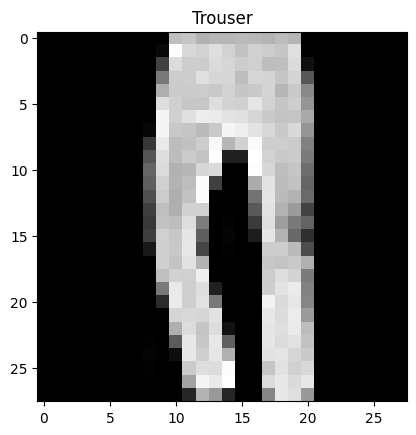

In [4]:
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

- lets predict the class of this image using the trained model


In [28]:
img = tr_images[ix] / 255
img = img.view(28*28).unsqueeze(0)
img = img.to('mps')
model.eval()
output = model(img).cpu().detach().numpy()
# apply softmax since model outputs 10 classes
probabas = np.exp(output) / np.sum(np.exp(output))
f"predicted label: {fmnist.classes[np.argmax(probabas)]}"

'predicted label: Trouser'

- so where does the model fail? 
- Translate the image multiple times one pixel at a time from a translation of 5 pixels to left to 5 pixels to right and store the predictions in a list


In [30]:
(tr_images[ix] / 255.).shape

torch.Size([28, 28])

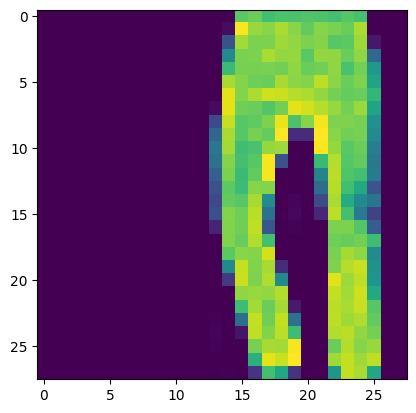

In [72]:
preds = []
model.eval()
for px in range(-5, 6):
    img = tr_images[ix] / 255.
    img = img.view(28, 28)
    # move image pixels horizontally
    img2 = np.roll(img, px, axis=1)
    # unsqueeze is needed due to the batch norm
    img3 = torch.Tensor(img2).view(28*28).unsqueeze(0).to("mps")
    output = model(img3).cpu().detach().numpy()
    probabas = (np.exp(output) / np.sum(np.exp(output))).tolist()[0]
    preds.append(probabas)

# lets see a single image
plt.imshow(img2)

<Axes: title={'center': 'Probability of each class for various translations'}>

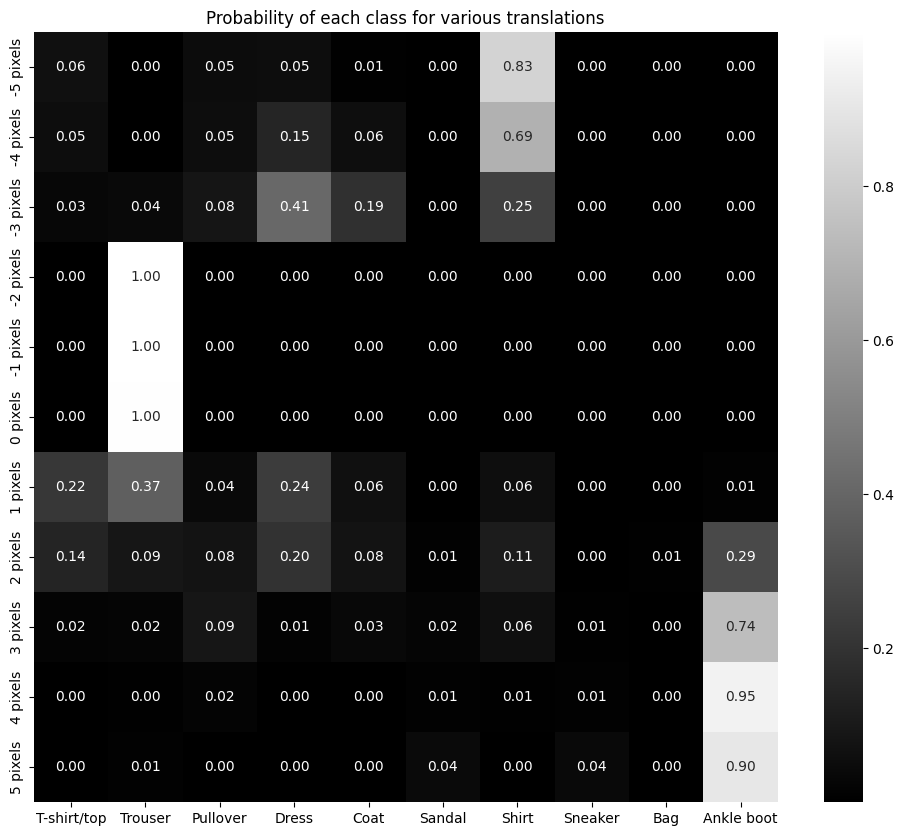

In [53]:
# visualize predictions
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title("Probability of each class for various translations");
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i) + str(' pixels') for i in range(-5, 6)], cmap='gray')

- There is no change in image's content since we only translated the images from 5 pixels to left and 5 pixels to right.  But the predicted class of the image changed when the translation was beyond 2 pixels.  This is because while the model was being trained, the content in all the training and testing images was at center.  This differs from preceding scenario where we tested with trasnlated images that are off center resulting in an incorrectly predicted class
- Hence above shows a scenario where traditional neural network fails. __CNN__ can address this problem

## Building Blocks of CNN
- Most common architectures used when working with images.
- Performs Image classification, object detection, image segmentation, used in GANs etc
- Addressed with some of the problems with traditional deep learning networks

## Convolution
- sliding window operation on a matrix using another matrix.  

In [63]:
def convolve_image(image_main, filter_matrix, k=3, flip=False, pad=False, stride=1):
    """Convolve a 2D image using the filter matrix.
    Args:
        image: a 2D numpy array.
        filter_matrix: a 2D numpy array otherwise called kernel
        k: window size
    Returns:
        the convolved image, which is a 2D numpy array same size as the input image.

    TODO: Implement the convolve_image function here.
    """
    kernel_dim = filter_matrix.shape[0]
    final_image = np.zeros_like(image_main)
    if pad:
        pad = (kernel_dim - 1)
        image_main = np.pad(image_main, [(pad, pad)], mode="constant")
    height, width = image_main.shape
    if flip:
        filter_matrix = np.fliplr(np.flipud(filter_matrix))
    for i in range(0, height - k + 1, stride):
        for j in range(0, width - k + 1, stride):
            final_image[i, j] = (
                image_main[i : k + i, j: k + j].ravel().dot(filter_matrix.ravel())
            )

    
    final_image = final_image[:, np.any(final_image, axis=0)]
    return final_image[np.any(final_image, axis=1), :]

filter_matrix = np.arange(1, 5).reshape(2, 2)
image = np.arange(1, 17).reshape(4, 4)

final_image = convolve_image(image, filter_matrix, k=2, pad=False)

In [101]:
final_image

array([[ 44,  54,  64],
       [ 84,  94, 104],
       [124, 134, 144]])

## Filter
- a filter is a matrix of weights thats initialized randomly at the start.  
- model learns optimal filter weights over increasing epochs
- the more filters there are in a CNN, the more features of the image the model can learn about.  Filters learn about different features present in the image.  
- a certain filter might learn about the ears of a cat and provide high activation value when the part of the image it is convolving with contains the ear of a cat.  
- we see that when a image of size 4x4 is convolved with a filter of size 2x2 , output is of size 3x3.  So, if we provide 10 different filters, we should get a 3x3x10 outputs.  So when an image is convolved by multiple filters, output has as many channels as there are filters that the image is convolved with.
- If we have a color image where there are 3 channels, filter that is convolving with the original image would also have 3 channels, resulting in a single scalar output per convolution. 
- If the filters are convolvingwith an intermediate output, say of size 64x112x112 in shape, filter would have 64 channels to fetch a scalar output.
- If there are 512 filters that are convolving with the output that was obtained with intermediate layer, output post convolution with 512 filters would be 512x111x111 in shape

## Strides and Padding
- in preceding section, each filter strode across the image - one column and one row at a time after exhausting all possible columns by end of image.  
- This resulted in output size being 1 pixel less than input size - both in terms of height and width.  
- This results in partial loss of information and can affect the possibility of us adding the output of the convolution operation to the original image (called residual addition)

In [102]:
convolve_image(image, filter_matrix, k=2, pad=False, stride=2)

array([[ 44,  64],
       [124, 144]])

## Padding
- in preceding case, we cannot multiply the leftmost elements of the filter with rightmost elemenets of the image.  If we perform such matrix multiplication, we need to pad with zeros.  This would ensure we can perform element to element multiplication of all the elements within an image within a filter

In [103]:
# i need to fix the convolve image function properly
convolve_image(image, filter_matrix, k=2, pad=True, stride=1)

IndexError: index 4 is out of bounds for axis 1 with size 4

## Pooling
- Pooling aggregates information in a small patch.  Look at a scenario where the output of convolution activation is as follows:


In [50]:
np.arange(1, 5).reshape(2, 2)

array([[1, 2],
       [3, 4]])

- max pooling for this is 4 where we look at  max of the elements in the matrix
- what if we have the following matrix?

In [51]:
np.arange(1, 17).reshape(4, 4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

- using a stride of 2, max pooling leads to 4 boxes where we take maximum within this box.  So maximum here is then:

In [53]:
pooling = np.array([[6, 8], [14, 16]])
pooling

array([[ 6,  8],
       [14, 16]])

- there is also sum pooling and average pooling.  But max pooling is used most often in practice
- Note that by end of performing convolution and pooling, size of original matrix is reduced from 4x4 to 2x2.  If original image was 200x200 and filter shape is 3x3 (most realistic scenario), output of convolution is 198x198 and then output of pooling would be 99x99


In [95]:
filter_matrix = np.arange(1, 10).reshape(3, 3)
image = np.arange(1, 40001).reshape(200, 200)

final_image = convolve_image(image, filter_matrix, k=3, pad=False)
final_image.shape

(198, 198)


### Putting it all together
- convolution, filters and pooling helps reduce dimension of the image
- another critical component is the flatten layer (fully connected layer)
- the output of previous pooling operation and then flattening is: [6, 8, 14, 16].  We can now treat this as input layer.  We can then pass this to __hidden layer__ and then obtain the output for predicting class of an image

-__summary of CNN architecture__:

- Take input, then convolve, then use RELU, then pool, then convolve + RELU, pool again
- then flatten the final pooling layer and send ti to softmax to make prediction of the label associated with this input
- the above summary forms the feature learning part where we are passing an image through convolution via multiple filters, and then pooling, repeating the convolution and pooling process twice, before flattening output fo the final pooling layer.  This process is the __feature learning__ part of preceding image

- convolution and pooling constitute feature learning section as filters help in extracting relevant features from images and pooling helps in aggregating information and thereby reducing the number of nodes at the flatten layer.  
- if we directly flattened the input image (300x300 pixels in size) for example, then we have 90k input values.  If we have 90k input pixel values and 100k nodes in __hidden layer__, we are looking at 9 billion parameters roughly.  
- convolution and pooling help in fetching flattened layer that has a much smaller representation than the original image.  
- __flatten layer serves as input to the hidden layer!!__
- last part of the classification is similar to way we classified images before where we had a hidden layer and obtained output layer


In [92]:
pooling.ravel()

array([ 6,  8, 14, 16])

## How convolution and pooling help in image translation
- when performing pooling, we consider the output of the operation as an abstraction of a region.  This comes in handy when images are translated
- suppose we translate image by 1 pixel to left.  Once we perform convolution, activation and pooling on top of it, we will have reduced teh dimension of the image (due to pooling)
- This means fewer number of pixels store majority of the information from the original image.  
- pooling stores information of a region (max pooling), hence information within a pixel of pooled image won't vary, even if original image is translated by 1 unit since maximum value of that region is likely to get captured  in the pooled image.  
- Convolutioin and pooling can also help us with __receptive field__ (look in the book chapter pg 178 for explanation)

## Building a CNN based architecture using PyTorch
- CNN architecture is composed of the following:
    - Convolution Operation
    - Pooling Operation
    - Flattening Layer
    - hidden layer
    - output layer

- Pytorch expects inputs to be of shape NxCxHxW where N is the number of batches, C is the number of channels, H is the height, W is the width of the image

In [43]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],[5,6,7,8],[1,3,4,5]]],[[[-1,2,3,-4],[2,-3,4,5],[-5,6,-7,8],[-1,-3,-4,-5]]]]).to('mps').float()
X_train /= 8
y_train = torch.tensor([0,1]).to('mps').float()

In [44]:
X_train

tensor([[[[ 0.1250,  0.2500,  0.3750,  0.5000],
          [ 0.2500,  0.3750,  0.5000,  0.6250],
          [ 0.6250,  0.7500,  0.8750,  1.0000],
          [ 0.1250,  0.3750,  0.5000,  0.6250]]],


        [[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='mps:0')

In [45]:
y_train

tensor([0., 1.], device='mps:0')

In [169]:
convolve_image(X_train[0][0].cpu().detach().numpy(), np.arange(1, 10).reshape(3, 3))

array([[25.875, 31.5  ],
       [22.375, 28.875]], dtype=float32)

In [46]:
learning_rate = 0.001
def get_model(learning_rate):
    model = nn.Sequential(
        # number of out channels is number of filters
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid(),
    ).to("mps")

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

# below implementation is to just test each of the layer functionality
"""class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Conv2d(1, 1, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.layer = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        pass
    """

'class Model(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.convolution = nn.Conv2d(1, 1, kernel_size=3)\n        self.pool = nn.MaxPool2d(2)\n        self.relu = nn.ReLU()\n        self.flatten = nn.Flatten()\n        self.layer = nn.Linear(1, 1)\n        self.sigmoid = nn.Sigmoid()\n\n    def forward(self, x):\n        pass\n    '

- in preceding model, we specify that there is one channel in input and we are extracting one channel from output post convolution with a filter of size 3x3.  
- after this, we perform max pooling using nn.MaxPool2d and ReLU activation and then flatten and connect to final layer which has one output per datapoint

In [47]:
# summary
from torchsummary import summary
model, loss_fn, optimizer = get_model(learning_rate)
summary(model, X_train);

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [48]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0628, -0.1245,  0.0189],
          [-0.1477, -0.2421, -0.1425],
          [-0.2478, -0.1728,  0.0506]]]], requires_grad=True)
Parameter containing:
tensor([0.0397], requires_grad=True)
Parameter containing:
tensor([[-0.0387]], requires_grad=True)
Parameter containing:
tensor([-0.4529], requires_grad=True)


### Observation
- looking at the summary, lets try to explain why there are 12 parameters in total
- we first specified size of convolving kernel (kernel size = 3) and that number of out_channels is 1 (number of filters) and number of input channels is 1
- each input image we are convolving a filter of shape 3x3 on a shape of 1x4x4 which results in an output of shape 1x2x2.  

In [190]:
# checking whether the 1x4x4 being convolved with a 3x3 filter leads to a 1x2x2 output
convolve_image(X_train[0][0].cpu().detach().numpy(), np.arange(1, 10).reshape(3, 3))
# yes it does

array([[25.875, 31.5  ],
       [22.375, 28.875]], dtype=float32)

- There are 10  parameters since we are learning 9 parameters from teh filter (3x3) and one bias involving the convolving kernel
- For maxpool2d, relu and flatten, there are no parameters as these are operations that are performed on top of the output of convolution layer; no weights or biases are involved
- linear layer has 2 parameters - one weight and one bias
- hence total of 12 parameters (10 from convolution, 2 from linear layer)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def train_model(x, y, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred.squeeze(0), y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

train_dl = DataLoader(TensorDataset(X_train, y_train),generator=torch.Generator(device='mps'))


NameError: name 'X_train' is not defined

In [38]:
for x_batch, y_batch in train_dl:
    break

In [50]:
print(x_batch)

tensor([[[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='mps:0')


In [205]:
# testing effect of each layer
"""
model = Model()
o = model.convolution(x_batch)
p = model.pool(o)
a = model.relu(p)
f = model.flatten(a)
l = model.layer(f)
s = model.sigmoid(l)
"""

In [51]:
model = model.to("mps")
for epoch in range(2000):
    for x_batch, y_batch in train_dl:
        batch_loss = train_model(x_batch, y_batch, model, optimizer, loss_fn)

In [52]:
model(X_train[:1])

tensor([[0.1273]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [29]:
X_train[:1]

tensor([[[[0.1250, 0.2500, 0.3750, 0.5000],
          [0.2500, 0.3750, 0.5000, 0.6250],
          [0.6250, 0.7500, 0.8750, 1.0000],
          [0.1250, 0.3750, 0.5000, 0.6250]]]], device='mps:0')

## Forward Propagating the output in Python
- We can extract the weights and biases of convolution and linear layers of architecture
- Below we will verify how CNNs work by manually calculating the result from the weights after fitting to verify our understanding

In [53]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [54]:
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer, 'weight')]

In [56]:
cnn_w.shape # one filter, one channel, that is 3x3

torch.Size([1, 1, 3, 3])

In [89]:
ans = convolve_image(X_train[0][0].cpu().detach().numpy(), cnn_w[0][0].cpu().detach().numpy()) + cnn_b.item()
ans = torch.tensor(ans).to("mps").float()

In [90]:
ans

tensor([[-2.0471, -2.6237],
        [-0.9382, -1.6903]], device='mps:0')

In [91]:
# apply pooling on top of ReLU (using clamp_min) then pass the result to linear layer
relu = ans.clamp_min_(0)
pooling_layer_output = torch.max(relu)
intermediate_output = pooling_layer_output * lin_w + lin_b

In [92]:
torch.sigmoid(intermediate_output) # matches answer above and repeating it below for verification

tensor([[0.1273]], device='mps:0')

In [93]:
model(X_train[:1])

tensor([[0.1273]], device='mps:0', grad_fn=<SigmoidBackward0>)

## Classifying Images using Deep CNN
- traditional NN predicts incorrectly for translated images.  In real world scenario, various augmentations will need to be applied such as translation and rotation that were not seen during the training phase.  
- Lets see how CNN address the problem of incorrect predictions when image translation happens on images in the Fashion MNIST dataset
- Also note, input to fashion MNIST isn't 28x28 = 784 dimensions which we did before, but reshape the input to a shape (1, 28, 28) for each image (channels are specified first, followed by height and width in PyTorch)

In [61]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn 

torch.set_default_device("mps")


val_fmnist = datasets.FashionMNIST(path, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1,1, 28, 28)
        self.x, self.y = x.float(), y.float()
    def __getitem__(self, ix):
        return self.x[ix].to('mps'), self.y[ix].to("mps")
    
    def __len__(self):
        return len(self.x)



def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    train_dl = DataLoader(train, batch_size=32, shuffle=True, generator=torch.Generator(device='mps'))
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True, generator=torch.Generator(device='mps'))
    return train_dl, val_dl


- Note that in the above, we are reshaping each input image since we are providing data to a CNN which expects each input to have shape of batch size x channels x height x width

In [174]:
tr_images.shape

torch.Size([60000, 28, 28])

In [175]:
tr_images[0].view(-1, 1, 28, 28).shape

torch.Size([1, 1, 28, 28])

In [176]:
tr_images[0].device

device(type='cpu')

In [177]:
learning_rate = 0.001
def get_model(learning_rate):
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10),
    ).to("mps")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer



In [178]:
model, loss_fn, optimizer = get_model(learning_rate)
summary(model, torch.zeros(1, 1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

- __layer 1__: There are 64 filters each of which is 3x3.  Hence 576 parameters + 64 biases which leads to 640 total parameters
- __layer 4__: Each filter is of size (3x3x64) since there are 64 input channels and there is one bias associated with this filter.  hence total of 577 parameters.  There are 128 filters applied for a total of 73,586 parameters which is given by ((3 * 3 * 64) + 1) * 128
- __layer 8__: layer with 3200 hidden units is connected to another layer with 256 units, we have total of 3200 * 256 + 256 biases = 819,456 parameters
- __layer 10__: layer with 256 units is connected with layer with 10 nodes, we need 2560 + 10 bias = 2570 parameters

- Hence total number of parameters to be estimated is: 896,252 parameters in total

640

In [179]:
def train_model(x, y, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [180]:

num_epochs = 5
train_dl, val_dl = get_data()
model = model.to("mps") # for some reason this is needed for it to train properly
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for x_batch, y_batch in train_dl:
        batch_loss = train_model(x_batch, y_batch, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x_batch, y_batch in train_dl:
        is_correct = accuracy(x_batch, y_batch, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x_batch, y_batch in val_dl:
        val_is_correct = accuracy(x_batch, y_batch, model)
        validation_loss = val_loss(x_batch, y_batch, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


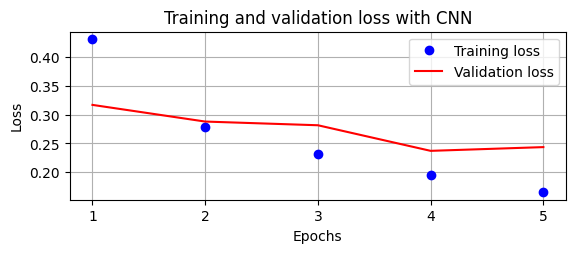

/var/folders/8q/h_918phj53q6hkl0scwf5fmr0000gn/T/ipykernel_7916/3843616543.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


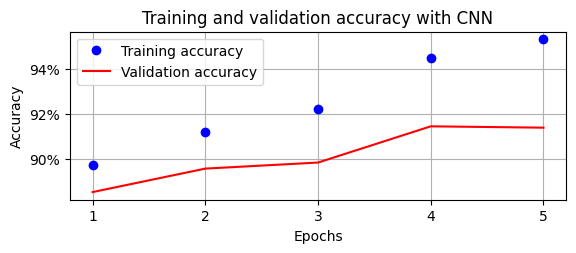

In [181]:

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

- Note that, accuracy of validation dataset is 92% even without any regularization within first 5 epochs which is already better than the accuracy we saw across various techniques in previous chapter.  
- lets now translate the image between -5 and 5 pixels and predict its class


Text(0.5, 1.0, 'Trouser')

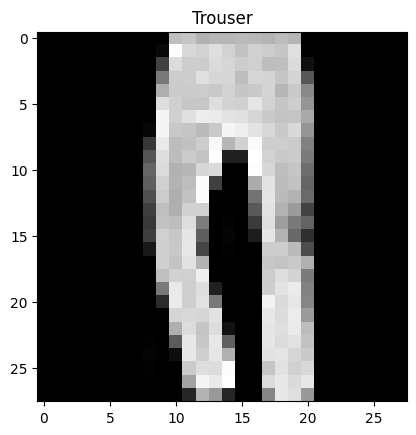

In [182]:
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

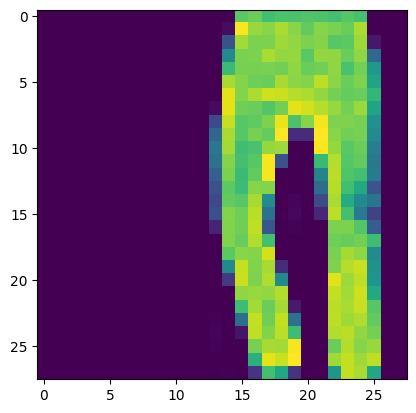

In [185]:
# translate the above images
# recall output is 10 classes
preds = []
model.eval()
ix = 24300
for px in range(-5, 6):
    img = tr_images[ix] / 255.
    img = img.view(28, 28)
    # move image pixels horizontally
    img2 = np.roll(img, px, axis=1)
    # reshape the image to -1, 1, 28, 28 so that we can pass it to CNN model
    # reshaping it to batch size x num channels x height x width
    img3 = torch.Tensor(img2).view(-1, 1, 28, 28).to("mps")
    output = model(img3).cpu().detach().numpy()
    probabas = (np.exp(output) / np.sum(np.exp(output))).tolist()[0]
    preds.append(probabas)

# lets see a single image
plt.imshow(img2)

<Axes: title={'center': 'Probability of each class for various translations'}>

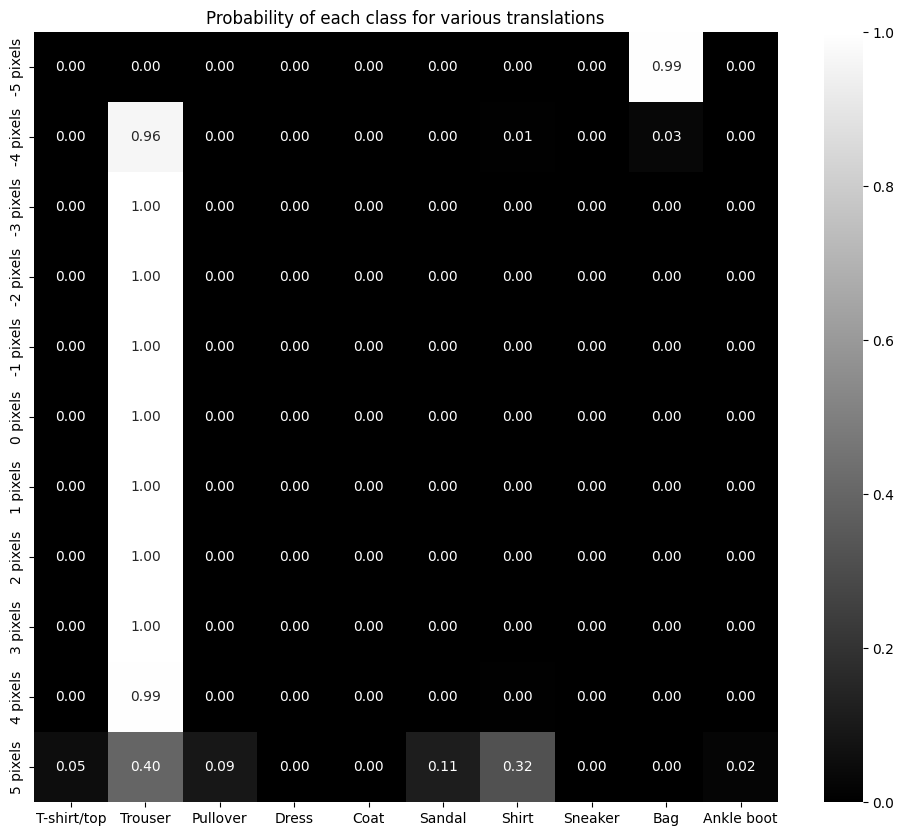

In [187]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title("Probability of each class for various translations");
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i) + str(' pixels') for i in range(-5, 6)], cmap='gray')

- even when the image was translated by 4 pixels, prediction is correct while in the case where we did not use CNN, prediction was incorrect when the image was translated by 4 pixels.  But when the image is translated by 5 pixels, probabilities of trouser dropped considerably
- CNN helps pto address challenge of image translation, but dont solve the problem completely.  We can address this by using data augmentation alongside CNN which will be covered next

## Image Augmentations
- In real world, we might encounter various scenarios such as:
    - images are rotated slightly
    - images are zoomed out/in
    - some amount of noise is present in image
    - images have low brightness
    - images have been flipped
    - images have been sheared (one side of image is more twisted)

- a neural network that does not take preceding scenarios into consideration won't provide accurate results just like in previous scenario where we had a neural network that had not been trained on images that are heavility translated
- image augmentation comes in handy in scenarios where we create more images from a given image.  Each created image can vary in terms of rotation, translation, scale, noise and brightness.  Furthermore, extent of variation in each of these parameters can also vary (example, translation of certain image in a given iteration can be +10 pixels, while in different iteration it can be -5)
- __augmenters__ class in the imgaug package has useful utilities for performing these augmentations.  
- some of most prominent techniques are: 
    - affine transformations
    - change brightness
    - add noise
- torchvision.transforms is another image augmentation pipeline

## Affine Transformations
- involve translating, rotation, scaling, and shearing an image
- we use the Affine method thats present in augmenters class
- Affine method has following parameters: 
    - scale: specifies amount of zoom that is to be done for image
    - translate_percent: specifies amount of translation as a percentage of image's height and width
    - translate_px specifies amount of translation as an absolute number of pixels
    - rotate: specifies amount of rotation that is to be done on image
    - shear: amount of rotation tht is to be done on part of an image

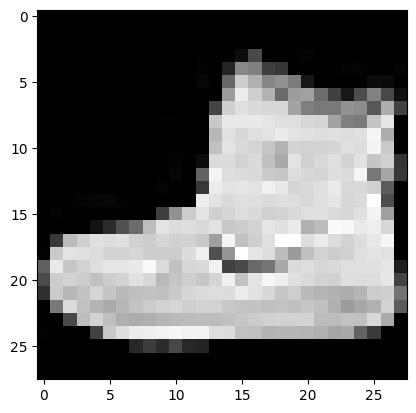

In [189]:
plt.imshow(tr_images[0], cmap='gray')

In [4]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Scaled Image')

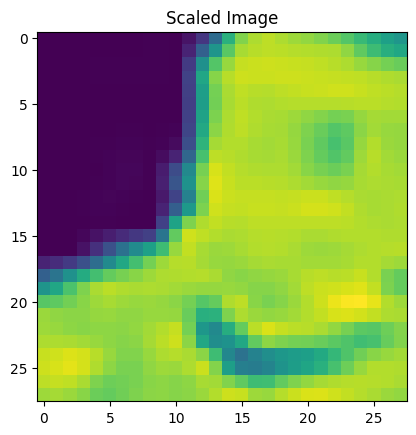

In [5]:
from imgaug import augmenters as iaa
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title("Scaled Image")

Text(0.5, 1.0, 'Translated image by 10 pixels (right and bottom)')

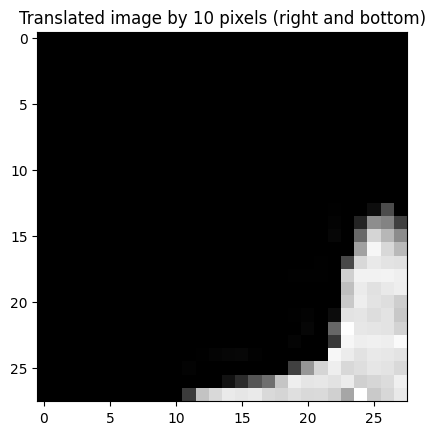

In [198]:
# translation by a certain number of pixels
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translated image by 10 pixels (right and bottom)')

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

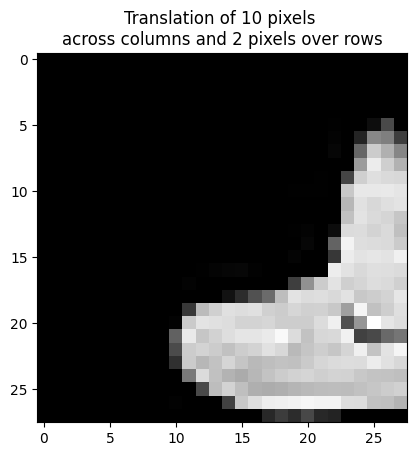

In [199]:
# translate x by 10, y by 2 pixels
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')

- preceding image shows that more translation happened across columns compared to rows.  This also resulted in certain portion of the image being cropped

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

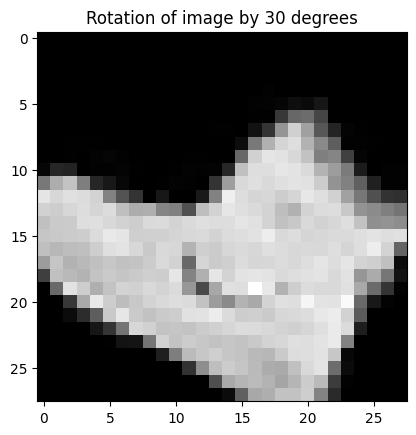

In [201]:
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by -30 degrees')

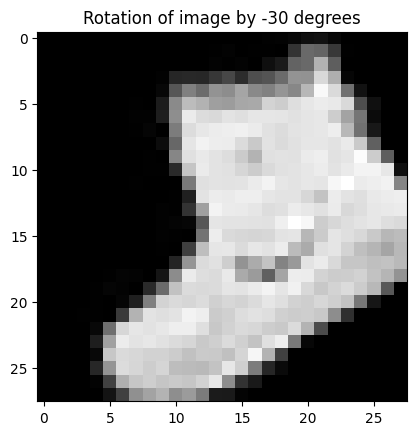

In [202]:
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by -30 degrees')
     

Text(0.5, 1.0, 'Shear of image by 30 degrees')

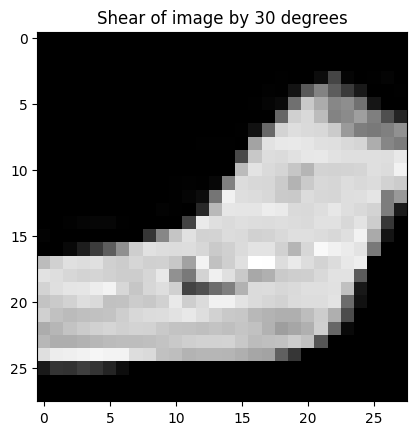

In [203]:

aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by 30 degrees')

Text(0.5, 1.0, 'Shear of image by -30 degrees')

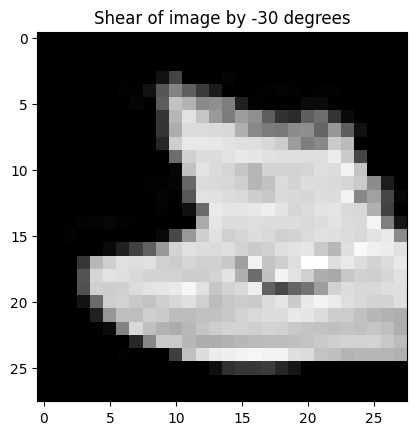

In [204]:

aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by -30 degrees')

- above pictures have been cropped post augmentation
- fit_output = True parameter helps us not to lose any information due to cropping post augmentation
- below shows augmentation of images with fit_output = False and then with fit_output = True

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

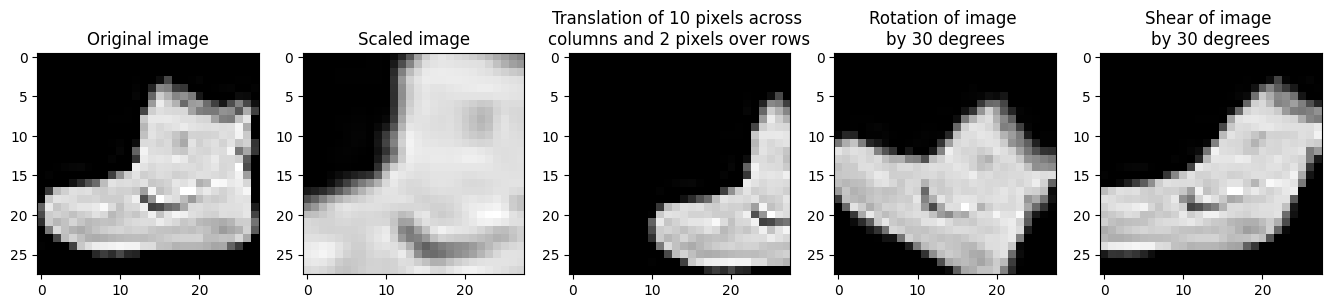

In [205]:
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

- we can see that in the majoirity of preceding images, certain pixels were cropped oout of the image post transformation. Fit_output can help with the preceding scenario

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

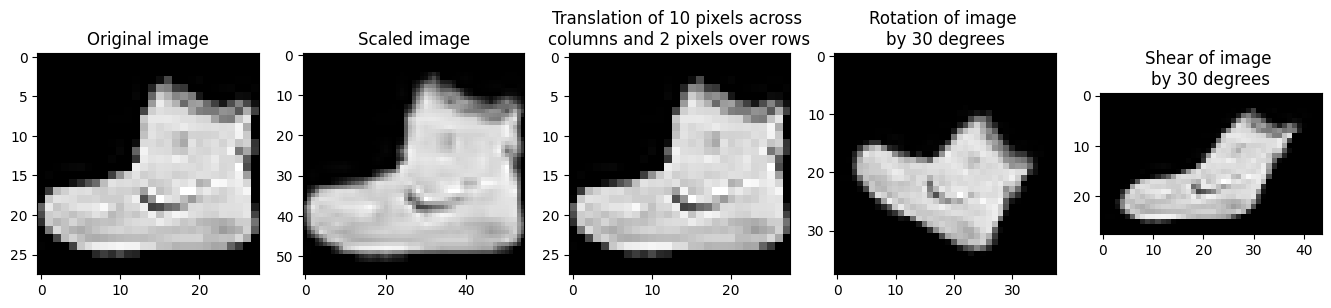

In [200]:
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

- when the original image hasn't been cropped, teh size of the augmented image increased to account for the augmented image not being cropped (in the scaled image's output or when rotating the image by 30 degrees).  Furthermore, the activation of fit_output parameter has negated the translation that we expected in teh translation of a 10-pixel image.  
- when size of augmented images increases (when image is rotated for example), we need to figure out how the new pixels that are not part of the original image should be filled in
- __cval__ parameterd solves this issue.  It specifies the pixel value of the new pixels that are created when fit_output = True.  In preceding images, cval is filled with default value of 0, which results in black pixels.  Lets change this to 255 and see how it impacts the output when an image is rotated

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

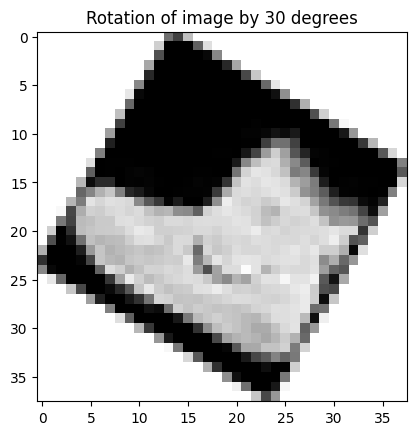

In [209]:
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title("Rotation of image by 30 degrees")

- there are different modes we can u se to fill the values of newly created pixels.  These values, which are for mode parameter, are as follows:
    - constant: Pad with a constant value
    - edge: pads with the edge values of the array
    - symmetric: Pads with reflection of the vector mirrored along the edge of the array
    - reflect: padswith reflection of the vector mirrored on the first and last values of the vector along each axis
    - wrap: pads with the wrap of the vector along the axis

Initial values are used to pad teh end, while end values are used to pad the beginning
outputs that we receive when cval is set to 0 and we vary teh mode parameter is as follows:



Text(0.5, 1.0, 'Rotation of image by \n30 degrees with wrap mode')

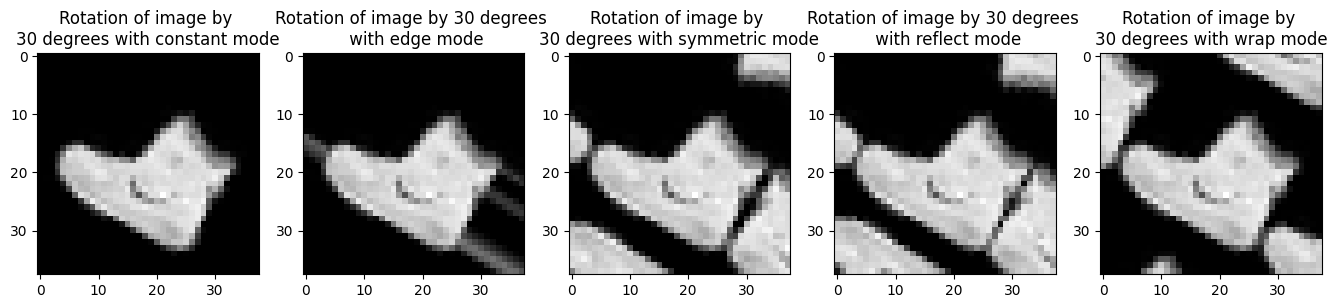

In [212]:
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')

- for current scenario based on Fashion MNIST dataset, it is more desirable to use constant mode for data augmentation
- so far, we specified that the translation needs to be a certain number of pixels or rotation angle needs be a specific degree.  
- In practice, it is difficult to specify the exact angle that an image needs to be rotated by.  So we can provide a range:

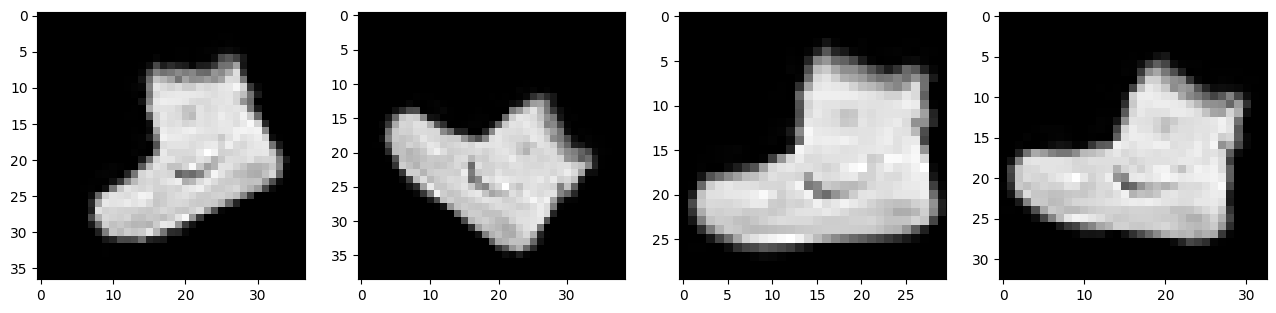

In [213]:

plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

- in preceding output, same image was rotated differently in different iterations because we specified a range of possible rotation angles in terms of upper and lower bounds of the rotation.  
- Similarly, we can randomize augmentations when we are translating or shearing an image
- lets now look at augmenting image brightness

## Changing Brightness of Image
- Imagine a scenario where the difference between background and foreground is not as distinct as we have seen so far.  So background does not have a pixel value of 0 and foreground does not have a pixel value of 255.  
- Such a scenario typically happens when lighting conditions in the image are different
- if background has pixel value of 0 and foreground has pixel value of 255 when the model has been trained but we are predicting an image that has background pixel value of 20 and foreground pixel value of 220, prediction is likely incorrect.
- __multiply__ and __Linearcontrast__ are two different augmentation techniques that can be leveraged to resolve such scenarios.  
- Linear contrast adjusts each pixel based on following formula: $127 + \alpha * (pixelvalue - 127)$
- In Linear contrast, based on above formula, when alpha is 1, pixel value remains unchanged.  But when alpha is less than 1, high pixel values are reduced and low pixel values is increased
- __multiply__ method multiplies each pixel value by teh value that we specify.  The output of multiplying each pixel value by 0.5 for the image we have been considering is as follows:


Text(0.5, 1.0, 'Pixels multiplied by 0.5')

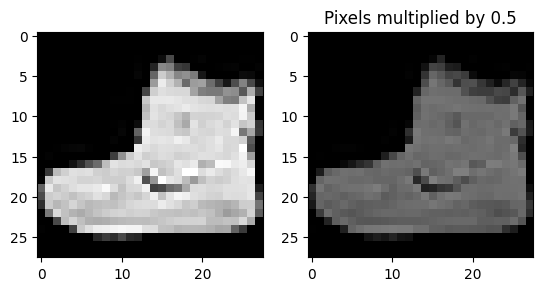

In [224]:
plt.subplot(121)
plt.imshow(tr_images[0], cmap='gray')
aug = iaa.Multiply(0.5)
plt.subplot(122)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', vmin=0, vmax=255)
plt.title("Pixels multiplied by 0.5")

Text(0.5, 1.0, 'Pixels contrast by 0.5')

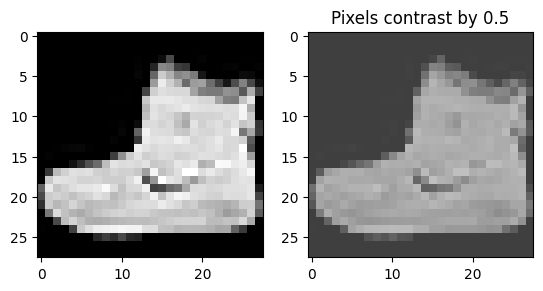

In [225]:
plt.subplot(121)
plt.imshow(tr_images[0], cmap='gray')
aug = iaa.LinearContrast(0.5)
plt.subplot(122)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', vmin=0, vmax=255)
plt.title("Pixels contrast by 0.5")

- Here we can see that background has become more bright and foreground pixel intensities has reduced.  
- Lets blur the image using gaussian blur (image can be blurred due to motion):
- in gaussian blue, as sigma increases, blur increases

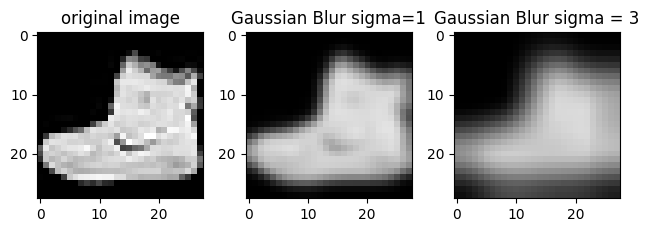

In [236]:
plt.subplot(131)
plt.imshow(tr_images[0], cmap='gray')
plt.title("original image");
aug = iaa.GaussianBlur(sigma=1)
plt.subplot(132)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', vmin=0, vmax=255)
plt.title("Gaussian Blur sigma=1")

aug = iaa.GaussianBlur(sigma=3)
plt.subplot(133)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', vmin=0, vmax=255)
plt.title("Gaussian Blur sigma = 3")
plt.tight_layout()

## Adding Noise
- in real world, we may encounter grainy images due to bad photography conditions.  
- Dropout and salt and pepper are two methods that can help in simulating grainy image conditions

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

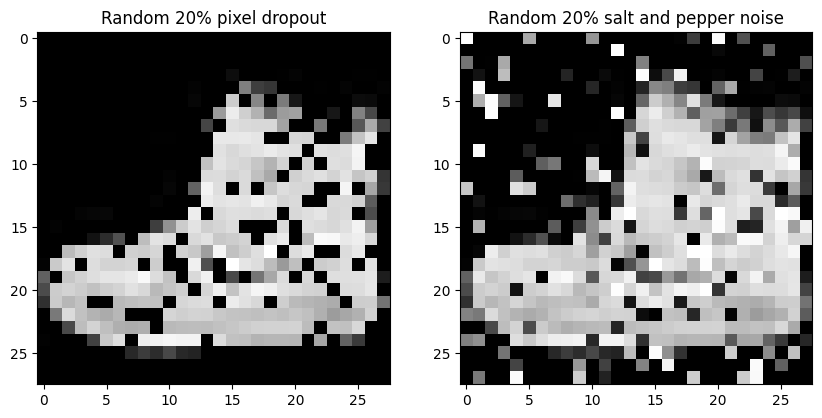

In [6]:

plt.figure(figsize=(10,10))
plt.subplot(121)
aug = iaa.Dropout(p=0.2,)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')
plt.subplot(122)
aug = iaa.SaltAndPepper(0.2,)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

- Dropout dropped certain amount of pixels randomly (it converted them so that they have a pixel value of 0)
- SaltAndPepper added some whiteish and blackish pixels randomly to our image

## Performing a sequence of augmentations
- in real world, we have to account for as many augmentations as possible.  We can use sequential as a way of performing augmentations

Text(0.5, 1.0, 'Image Augmented using random order of two augmentations')

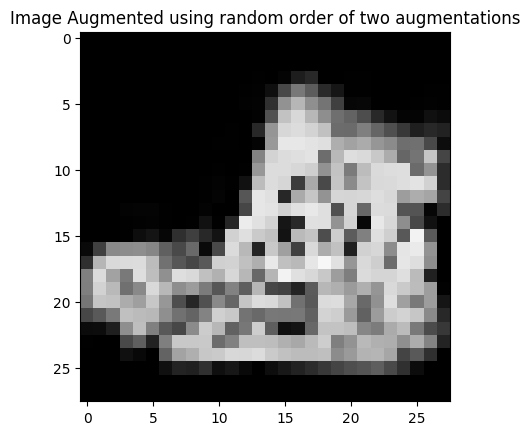

In [7]:
# perform a random order of augmentation, i.e first rotate then dropout, or first dropout then rotate
seq = iaa.Sequential([
                        iaa.Dropout(p=0.2),
                        iaa.Affine(rotate=(-30, 30))
                     ], 
                     random_order=True)
plt.imshow(seq.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Image Augmented using random order of two augmentations')

## Performing data augmentation on a batch of images and the need for collate_fn

In [8]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y 
        self.aug = aug
    
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x, y
    
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):
        ims, classes = zip(*batch)
        ims = torch.stack(ims)
        if self.aug:
            ims = self.aug.augment_images(images=to_numpy(ims))
        ims = torch.tensor(ims)[:, None, :, :].to('mps') / 255.0
        classes = torch.tensor(classes).to('mps')
        return ims, classes 

In [9]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant'),
])
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    'notice the collate_fn argument'
    trn_dl = DataLoader(train, batch_size=64,
                collate_fn=train.collate_fn, shuffle=True, generator=torch.Generator(device='mps'))
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                collate_fn=val.collate_fn, shuffle=True, generator=torch.Generator(device='mps'))
    return trn_dl, val_dl

def get_model(learning_rate):
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to('mps')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

def train_model(x, y, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

val_fmnist = datasets.FashionMNIST(path, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [96]:
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(learning_rate=learning_rate)

num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    for x_batch, y_batch in train_dl:
        train_model(x_batch, y_batch, model, optimizer, loss_fn)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


Text(0.5, 1.0, 'Trouser')

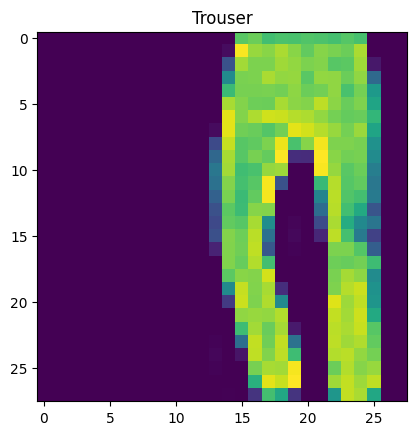

In [97]:
preds = []
model.eval()
ix = 24300
for px in range(-5, 6):
    img = tr_images[ix] / 255.
    img = img.view(28, 28)
    # move image pixels horizontally
    img2 = np.roll(img, px, axis=1)
    # reshape the image to -1, 1, 28, 28 so that we can pass it to CNN model
    # reshaping it to batch size x num channels x height x width
    img3 = torch.Tensor(img2).view(-1, 1, 28, 28).to("mps")
    output = model(img3).cpu().detach().numpy()
    probabas = (np.exp(output) / np.sum(np.exp(output))).tolist()[0]
    preds.append(probabas)

# lets see a single image
plt.imshow(img2)
plt.title(f"{fmnist.classes[np.argmax(probabas)]}")

<Axes: title={'center': 'Probability of each class for various translations'}>

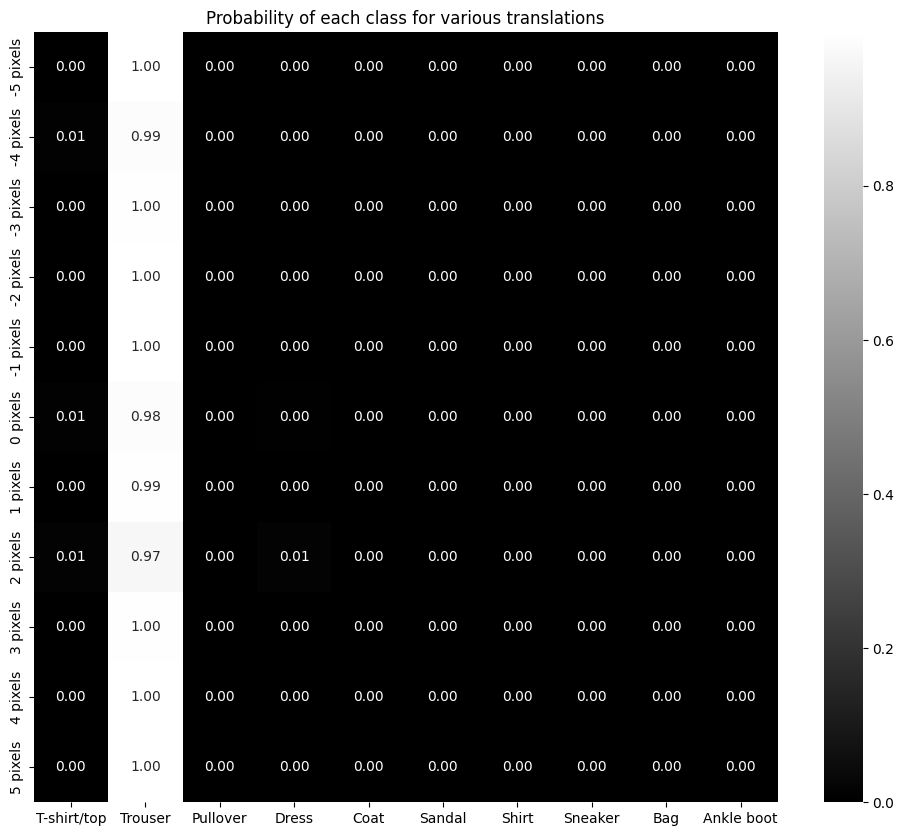

In [99]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title("Probability of each class for various translations");
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i) + str(' pixels') for i in range(-5, 6)], cmap='gray')

- Note that now the prediction does not vary, thus ensuring that image translation is taken care of by training our model on augmented translated images

## Visualizing the outcome of feaeture learning
- CNN helps us classify images, even when the objects in the images have been translated.
- Filters play a key role in learning the features of an image, which help in classifying the image in the right class.  
- What do the filters learn that makes them very powerful?
- Lets look at images that contain Xs and Os and see what the filters learn that enables CNN to classify image correctly
- get the data from datasets folder where the class of the image can be obtained from the image's name (first character of image's name specifies the class it belongs to)

In [10]:
import cv2 
from glob import glob
from imgaug import augmenters as iaa 

# define class that fetches data, ,ensure images have been resiized to 28x28, batches are shaped with 3 channels and dependent variable is fetched as numeric value
tfm = iaa.Sequential(iaa.Resize(28))

class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:, :, 0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255, dtype=torch.float32).to("mps").float(), torch.tensor([cl]).float().to('mps')

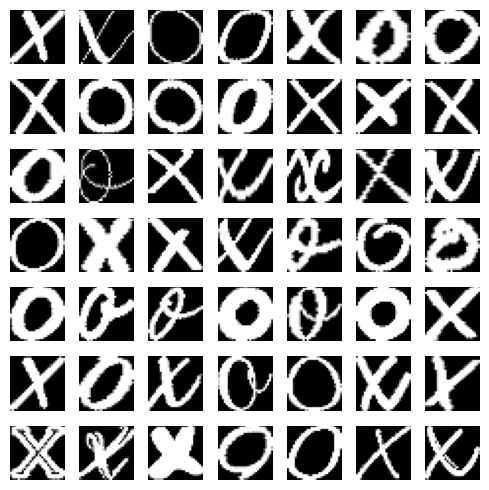

In [11]:
xopath = os.path.join(os.getcwd(), 'datasets', 'all', '*')
data = XO(xopath)
R,C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5, 5))
for label, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False);
        plot_cell.axis('off');
        ix = np.random.choice(1000)
        im, label = data[ix]
        plot_cell.imshow(im[0].cpu(), cmap='grey')
plt.tight_layout()

In [12]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(5*5*128, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to('mps')

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [13]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass s

In [14]:
def train_model(x, y, model, opt, loss_fn):
    model.train()
    
    # 1. Generate predictions
    pred = model(x)
    # check accuracy
    is_correct = (pred > 0.5) == y
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item(), is_correct[0]

In [15]:
train_dl = DataLoader(data, batch_size=32, drop_last=True, generator=torch.Generator(device='mps'))
model, loss_fn, optimizer = get_model()


In [16]:
for epoch in range(5):
    for xbatch, ybatch in iter(train_dl):
        batch_loss = train_model(xbatch, ybatch, model, optimizer, loss_fn)

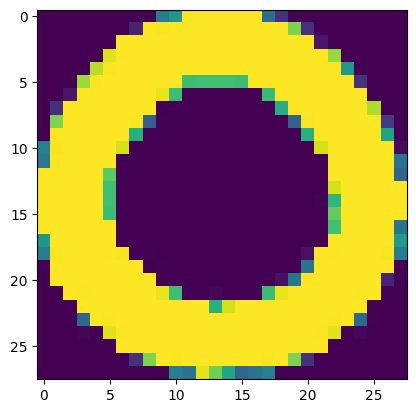

In [17]:
# fetch an image to check what the filters learn about the image
im, c = train_dl.dataset[1]
plt.imshow(im[0].cpu())

In [18]:
# pass the image through the trained model and fetch the output of the first layer then store it in intermediate output variable
first_layer = nn.Sequential(*list(model.children())[:1])

In [19]:
first_layer

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
)

In [20]:
intermediate_output = first_layer(im[None])[0].detach()

In [21]:
im[None].shape

torch.Size([1, 1, 28, 28])

In [22]:
first_layer(im[None]).shape

torch.Size([1, 64, 26, 26])

In [23]:
intermediate_output.shape

torch.Size([64, 26, 26])

- plot the toutput of first 64 filters.  Each channel in intermediate output is the output of hte convolution for each filter

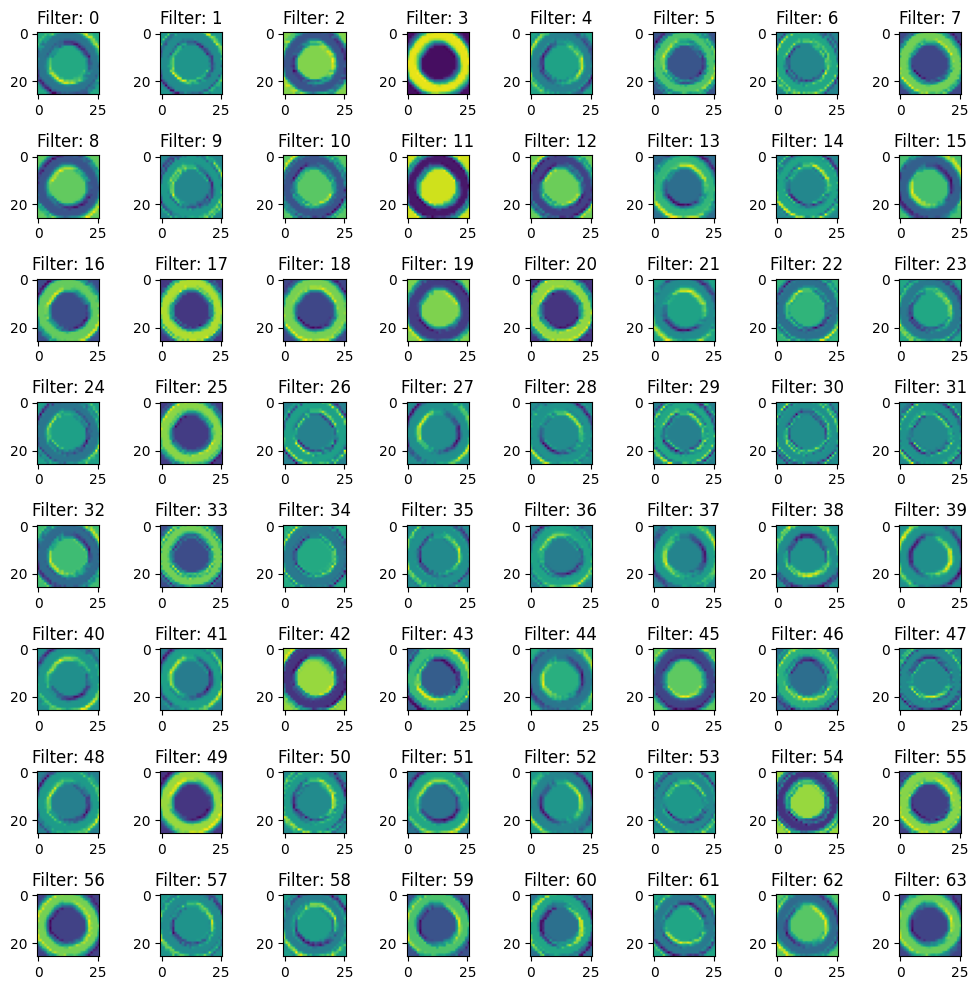

In [24]:
# plot the toutput of first 64 filters.  Each channel in intermediate output is the output of hte convolution for each filter
fig, ax = plt.subplots(8, 8, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: ' + str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

- we can see that certain filters such as filter 6 learn to invert the image while other filters learn about the edges in the picture
- next we will pass multiple O filters and inspect the output of the sixth filter across the images

In [25]:
x, y = next(iter(train_dl)) # recall its batch of 32
x2 = x[y==0]

In [26]:
x2 = x2.view(-1, 1, 28, 28)

In [27]:
x2.shape

torch.Size([13, 1, 28, 28])

In [28]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

In [29]:
first_layer_output.shape

torch.Size([13, 64, 26, 26])

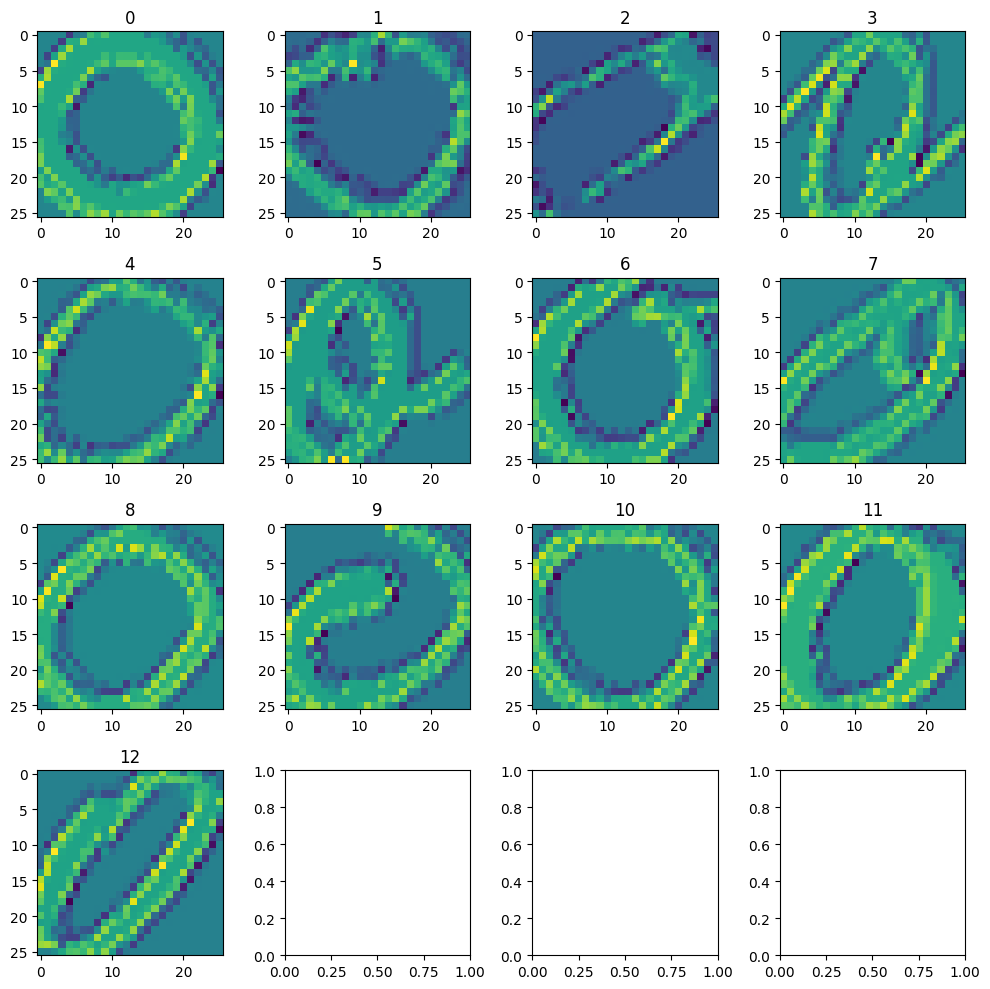

In [30]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    if ix > 12:
        break
    axis.imshow(first_layer_output[ix, 6, :, :].cpu())
    axis.set_title(str(ix))
plt.tight_layout()


- Notice what each of 6th filter is learning across the images.  Its pretty consistent

- Lets create another model that extracts layers until 2nd convolution layer (until four layers defined in preceding model) and extracts output by passing the original O image.  
- We then plot hte output of convolving the filters in the 2nd layer with the input O image

In [31]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_layer_output = second_layer(im[None])[0].detach()

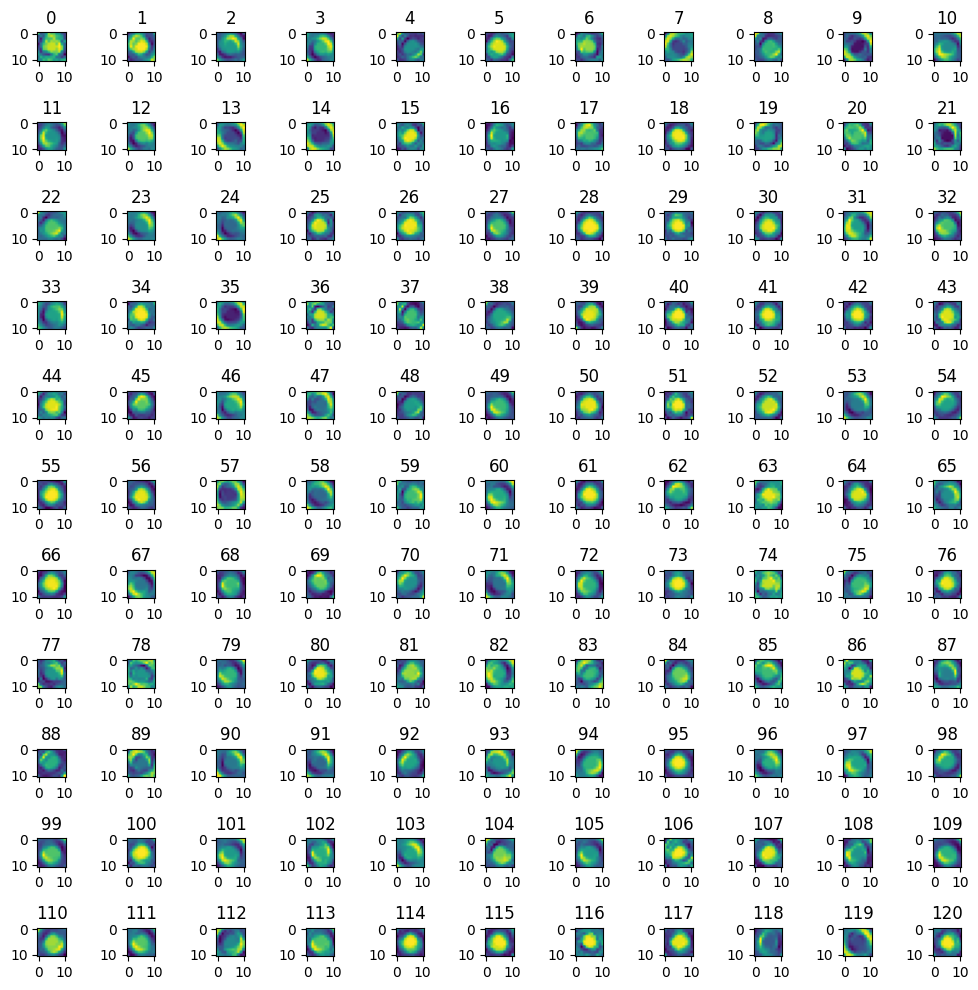

In [32]:
fig, ax = plt.subplots(11, 11, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_layer_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()


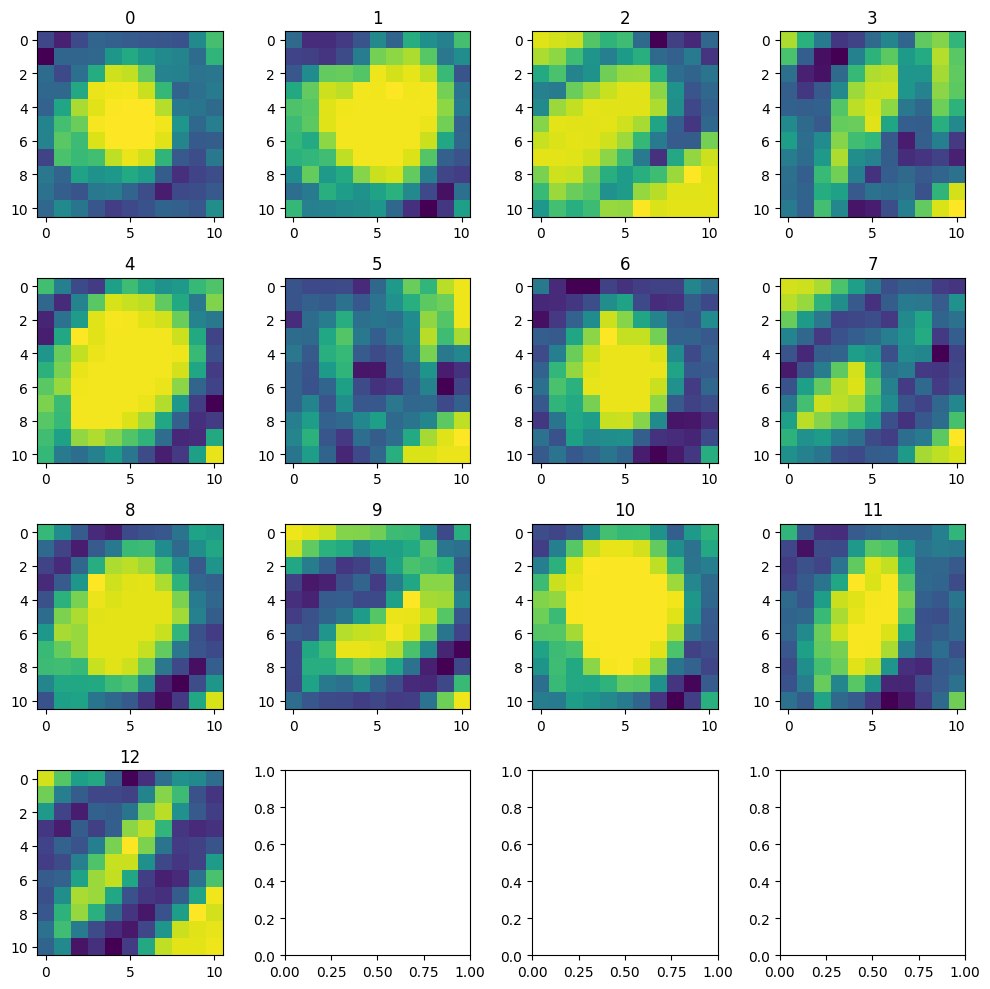

In [33]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_output = second_layer(x2).detach()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    if ix > 12:
        break
    axis.imshow(second_output[ix, 34, :, :].cpu())
    axis.set_title(str(ix))
plt.tight_layout()

- some notes to write here...

## Building a CNN for classifying a real world Images
- We learned how to perform image classification on the Fashion-MNIST dataset.  Now we will classify images ot dogs and cats

In [522]:
import torchvision
import torch.nn as nn 
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import glob
from torchsummary import summary
import numpy as np, pandas as pd, cv2
import os
import random
from PIL import Image

In [583]:
import torchvision.transforms as transforms
img_height, img_width = 224, 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width))
])
class CatsDogs(Dataset):
    def __init__(self, folder, transform=None):
        cats = glob.glob(folder + '/cats/*.jpg')
        dogs = glob.glob(folder+'/dogs/*.jpg')
        self.file_list = cats + dogs
        random.shuffle(self.file_list)
        self.labels = [path.split('/')[-1].startswith('dog') \
                          for path in self.file_list]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[idx]
        return img.to("mps"), torch.tensor([label], dtype=torch.float32).to("mps")

In [515]:
folder = os.path.join(os.getcwd(), 'cv_with_pytorch', 'datasets', 'cat_and_dog_images')
train_folder = os.path.join(folder, 'training_set')
test_folder = os.path.join(folder, 'test_set')
data = CatsDogs(train_folder, transform=transform)
img, label = data[200]

In [516]:
# even this works
#Image.open(data.file_list[200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


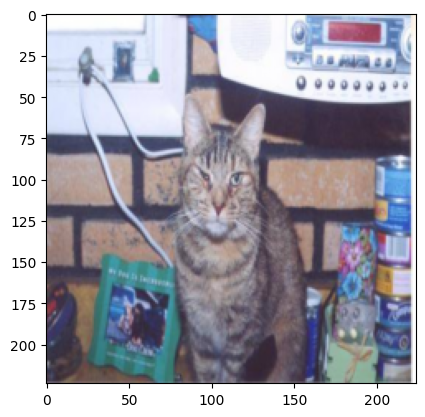

In [517]:
plt.imshow(img.permute(1, 2, 0))

- Lets define a convolution layer where we perform convolution, ReLU activation and batch normalization, max pooling
- Then define a get_model function which performs multiple convolutions and pooling operations by calling conv_layer method, flattens the output and connects the hidden layer to it
prior to connecting to output layer

In [584]:
def conv_layer(input_channels, output_channels, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(output_channels),
        nn.MaxPool2d(2)
    )

def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to('mps')
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [579]:
model, loss_fn, optimizer = get_model()


In [580]:
zeros = torch.zeros(1, 3, 224, 224, dtype=torch.float32)
summary(model, zeros);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [599]:
def get_data():
    train_ds = CatsDogs(train_folder, transform=transform)
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True, generator=torch.Generator(device='mps'))
    val_ds = CatsDogs(test_folder, transform=transform)
    val_dl = DataLoader(val_ds, batch_size=32, drop_last=True, generator=torch.Generator(device='mps'))
    return train_dl, val_dl

def train_model(x, y, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [600]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"Training for epoch: {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_model(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


Training for epoch: 1
Training for epoch: 2
Training for epoch: 3
Training for epoch: 4
Training for epoch: 5


In [605]:
len(val_losses)

0

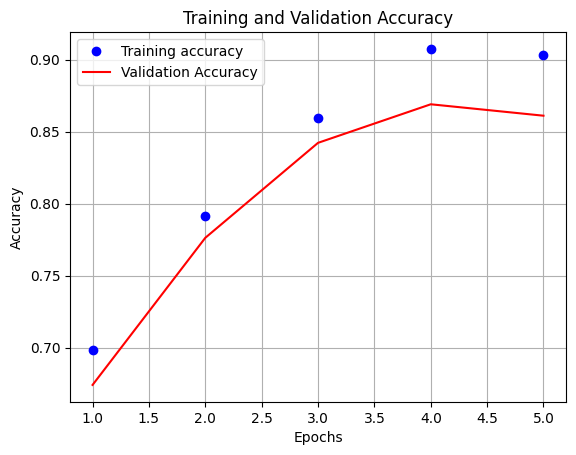

In [606]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy');
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy');
plt.title("Training and Validation Accuracy");
plt.xlabel("Epochs");
plt.ylabel("Accuracy");
plt.grid();
plt.legend();

- Classification accuracy at end of 5 epochs is ~86%
- Batch Norm has great impact on improving accuracy (try training without batch norm.  We can train without batch norm if we use fewer parameters such as reducing the number of layers, increasing stride, increasing pooling or resizing the image to a number lower than 224x224)

## What Impact does number of samples have on accuracy ?